In [2]:
from functools import reduce
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy
import pandas as pd
from scipy.optimize import minimize

In [3]:
num_stairs = 10
num_examples = 10
adv_eps = (1.0 / 3)
noise_eps = 0.1
x_noise = 0.005
slope = 1
#theta = np.random.randn(feats.shape[1])
lamda = 0.01
np.set_printoptions(precision=5)

knots = np.r_[np.arange(num_stairs), np.arange(num_stairs)-adv_eps, np.arange(num_stairs)+adv_eps]
knots = np.sort(knots)

# weights on different stairs
weights_1 = np.asarray([1/5]*5)
weights_2 = np.asarray([0.01]*(num_stairs-5))
weights = np.concatenate([weights_1, weights_2])
weights /= np.sum(weights)

Result = namedtuple('Result', ['x'])

In [4]:
def generate_x_noise(n):    
    # with probability x_noise there is noise
    unit_noise = (np.random.rand(n) < 0.5).astype(float)
    noise_mask = (np.random.rand(n) < x_noise).astype(float)
    return noise_mask * (unit_noise*2 - 1)*adv_eps

def data_gen(n, weights):
    num_stairs = len(weights)
    # sample from categorical distribution
    X = np.random.choice(num_stairs, p=weights, size=n).astype(float)
    return X

def label_noise(n, eps):
    return eps * np.random.randn(n)

def get_test_set():
    num_samples_per_stair = 10000
    # X_test has every row a different class and columns are samples from that class
    y_test = slope*np.arange(num_stairs).astype(float)[:, np.newaxis] * np.ones((num_stairs, num_samples_per_stair))
    X_test = np.arange(num_stairs).astype(float)[:, np.newaxis]
    noise = (np.random.rand(num_stairs, num_samples_per_stair)*2 - 1)*adv_eps
    X_test = X_test + noise
    return X_test, y_test

def get_feats(X, knots):
    X = X[:, np.newaxis]
    M = 4
    aug = np.arange(1, M+1)
    knots = np.r_[aug - M - 1 - knots[0], knots, aug + knots[-1]]

    K = len(knots)
    bases = (X >= knots[:-1]).astype(np.int) * (X < knots[1:]).astype(np.int)
    # do recursion from Hastie et al. vectorized
    maxi = len(knots) - 1
    for m in range(2, M+1):
        maxi -= 1

        # left sub-basis
        num = (X - knots[:maxi])* bases[:, :maxi]
        denom = knots[m-1 : maxi+m-1] - knots[:maxi]
        left = num/denom

        # right sub-basis
        num = (knots[m : maxi+m] - X) * bases[:, 1:maxi+1]
        denom = knots[m:maxi+m] - knots[1 : maxi+1]
        right = num/denom

        bases = left + right
    return bases


In [5]:
def sqerr(feats, y, theta): 
    return np.square(feats.dot(theta) - y).sum()

def sparse_diff(array, n=1, axis=-1):                                                                                                                 
    if (n < 0) or (int(n) != n):                                                
        raise ValueError('Expected order is non-negative integer, '             
                         'but found: {}'.format(n))                             
    if not scipy.sparse.issparse(array):                                        
        warnings.warn('Array is not sparse. Consider using numpy.diff')         
                                                                                
    if n == 0:                                                                  
        return array                                                            
                                                                                
    nd = array.ndim                                                             
    slice1 = [slice(None)]*nd                                                   
    slice2 = [slice(None)]*nd                                                   
    slice1[axis] = slice(1, None)                                               
    slice2[axis] = slice(None, -1)                                              
    slice1 = tuple(slice1)                                                      
    slice2 = tuple(slice2)                                                      
                                                                                
    A = sparse_diff(array, n-1, axis=axis)                                      
    return A[slice1] - A[slice2]

def first_derivative(n, order=2):
    if n == 1:                                                                  
        # no derivative for constant functions                                  
        return scipy.sparse.csc_matrix(0.)                                      
    D = sparse_diff(scipy.sparse.identity(n).tocsc(), n=order).tolil()          
    return np.asarray(D.tocsc().todense())

def derivative(n, order=2):                                                     
    if n == 1:                                                                  
        # no derivative for constant functions                                  
        return scipy.sparse.csc_matrix(0.)                                      
    D = sparse_diff(scipy.sparse.identity(n).tocsc(), n=order).tolil()          
    return np.asarray(D.dot(D.T).tocsc().todense()) 

def get_P(knots, with_intercept=False):
    P = derivative(len(knots) + 4, order=2) 
    return P

def norm(theta):
    return P.dot(theta).dot(theta)

def T(x):
    x_round = np.round(x)
    return [x_round-adv_eps, x_round,  x_round+adv_eps]
    
def sqerr_adv(theta, T_feats):
    sqerrs = [np.square(dat.dot(theta) - y) for dat in T_feats]
    max_errs = np.sum(np.maximum.reduce(sqerrs))
    return max_errs

def test_sqerr(X_test, theta): 
    def err_y_for_x(x, e_y):                                                    
        x_feats = get_feats(np.asarray([x]), knots)                             
        preds_x = x_feats.dot(theta)[0]                                         
        err_for_pt = np.square(preds_x) - 2*preds_x*e_y + noise_eps**2 + np.square(e_y)
        return err_for_pt                                                       
                                                                                
    total_err = []                                                              
    for i in range(X_test.shape[0]):                                                                                                            
        class_i_err = 0                                                     
        for x in [i-adv_eps, i+adv_eps]:                                    
            class_i_err += 0.5 * x_noise * err_y_for_x(x, slope*i)                                                                
        class_i_err += (1-x_noise)*err_y_for_x(i, slope*i)                      
        total_err.append(class_i_err)                                           
    total_err = np.asarray(total_err)                                           
    return np.sum(total_err * weights)

def summarize(theta, X, y, X_test):
    T_feats = [get_feats(xx, knots) for xx in [X, X-adv_eps, X+adv_eps]]
    feats = np.array(T_feats[0])
    print("sq err train")
    print(sqerr(feats, y, theta)/X.shape[0])
    print("sq err adv train")
    print(sqerr_adv(theta, T_feats)/X.shape[0])
    print("sq err test")
    print(test_sqerr(X_test, theta))
    print("generalization gap")
    print(test_sqerr(X_test, theta) - sqerr(feats[0], y, theta)/X.shape[0])
    print("rkhs norm")
    print(norm(theta))

In [6]:
def solve_normal(f_mat, labels, l):
    mat = f_mat.T.dot(f_mat) + l * get_P(knots)
    theta = np.linalg.pinv(mat).dot(f_mat.T.dot(labels))
    res_normal = Result(x=theta)
    return res_normal

def solve_gr(f_mat, y, lamda, beta=1.0):
    def f0(w):
        loss = np.dot(f_mat, w) - y
        objective = (
            np.sum(loss**2) \
            + lamda*np.dot(np.dot(w, P), w) \
            + beta / 2 * np.linalg.norm(loss.reshape(-1, 1) * f_mat, axis=1).sum()
        )
        return objective
           
    res = minimize(f0, np.zeros(f_mat.shape[1]), method='L-BFGS-B')
    return Result(x=res.x)

def solve_llr(T_feats, y, lamda, P, knots_idx, beta=1.0):
    def f0(w):
        sum_sq = [np.sum((np.dot(dat, w) - y)**2) for dat in T_feats]
        temp = adv_eps * 2 * np.sum(np.dot(np.dot(D[knots_idx], w), (np.dot(T_feats[1], w) - y)))
        l0 = sum_sq[0] - sum_sq[1] + temp
        l1 = sum_sq[2] - sum_sq[1] - temp
        return sum_sq[1] + beta*np.max([l0, l1]) + lamda*np.dot(np.dot(w, P), w)
        
    res = minimize(f0, np.zeros(T_feats[0].shape[1]))
    return Result(x=res.x)
    

def solve_adv(T_feats, y, lamda, P):
    theta_var = cp.Variable(T_feats[0].shape[1])
    sum_sq = [cp.square(dat*theta_var - y) for dat in T_feats]
    objective = cp.Minimize(cp.sum(reduce(cp.maximum, sum_sq)) + lamda*cp.quad_form(theta_var, P))
    prob = cp.Problem(objective)
    prob.solve()
    return Result(x=theta_var.value)

def solve_trades(T_feats, y, lamda, P, beta):
    theta_var = cp.Variable(T_feats[0].shape[1])
    mse = cp.square(T_feats[1]*theta_var - y)
    sum_sq = [cp.square(dat*theta_var - T_feats[1]*theta_var) for dat in T_feats]
    objective = cp.Minimize(cp.sum(mse) + beta * cp.sum(reduce(cp.maximum, sum_sq)) + lamda*cp.quad_form(theta_var, P))
    prob = cp.Problem(objective)
    prob.solve()
    return Result(x=theta_var.value)

In [7]:
D = derivative(len(knots) + 4, order=1) 
P = get_P(knots)

In [8]:
def calc_mse_err(theta, X, y):
    feats = get_feats(X, knots)
    #feats = np.array([get_feats(x, knots) for x in X])
    mse = (np.dot(feats, theta) - y)**2
    return mse.mean()

def calc_lip(theta, X, y):
    preds = np.array([np.dot(get_feats(x, knots), theta) for x in [X-adv_eps, X+adv_eps]])
    lip = (np.abs(preds - y)).max(0) / adv_eps
    return lip.mean()

def adv_mse_err(theta, X, y):
    preds = np.array([np.dot(get_feats(x, knots), theta) for x in [X-adv_eps, X, X+adv_eps]])
    mse = ((preds - y)**2).max(0)
    return mse.mean()

def get_sol(trnX, trny, tstX, tsty, prob, beta=1, cv="nor"):
    feats = get_feats(trnX, knots)
    T_feats = [get_feats(xx, knots) for xx in [trnX-adv_eps, trnX, trnX+adv_eps]]
    #tst_feats = get_feats(tstX, knots)
    
    #lamdas = [1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]
    lamdas = [1e-2]
    mse_err = []
    adv_err = []
    trn_mse_err = []
    rets = []
    
    for lamda in lamdas:
        if prob == "normal":
            res = solve_normal(feats, trny, lamda)
        elif prob == "llr":
            knots_idx = np.argmin(np.abs(trnX.reshape(-1, 1) - knots.reshape(1, -1)), axis=1) + 2
            res = solve_llr(T_feats, trny, lamda, P, knots_idx, beta=beta)
        elif prob == "gr":
            res = solve_gr(feats, trny, lamda, beta=beta)
        elif prob == "adv":
            res = solve_adv(T_feats, trny, lamda, P)
        elif prob == "trades":
            res = solve_trades(T_feats, trny, lamda, P, beta=beta)
        theta = res.x
        trn_mse_err.append(calc_mse_err(theta, trnX, trny))
        adv_err.append(adv_mse_err(theta, trnX, trny))
        mse_err.append(calc_mse_err(theta, tstX, tsty))
        rets.append(theta)

    print(mse_err)
    #print(adv_err)
    if cv == "trnor":
        return rets[np.argmin(trn_mse_err)]
    elif cv == "nor":
        return rets[np.argmin(mse_err)]
    else:
        return rets[np.argmin(adv_err)]

def print_results(theta, trnX, trny, tstX, tsty):
    trn_mse = calc_mse_err(theta, trnX, trny)
    tst_mse = calc_mse_err(theta, tstX, tsty)
    adv_trn_mse = adv_mse_err(theta, trnX, trny)
    adv_tst_mse = adv_mse_err(theta, tstX, tsty)
    trn_lip = calc_lip(theta, trnX, trny)
    tst_lip = calc_lip(theta, tstX, tsty)

    
    #print(f"trn mse: {trn_mse}")
    #print(f"advtrn mse: {adv_trn_mse}")
    
    #print(f"tst mse: {tst_mse}")
    #print(f"advtst mse: {adv_tst_mse}")
    
    #print(f"gap: {-trn_mse + tst_mse}")
    #print(f"adv gap: {-adv_trn_mse + adv_tst_mse}")
    return trn_mse, tst_mse, adv_trn_mse, adv_tst_mse, trn_lip, tst_lip


[0.019183212647732255]
[0.21863925948456103]
[0.22347628129927544]
[0.33600345100430534]
[0.0553505452994644]
[0.07855917392494427]
[0.15714348055137456]
\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr MSE &  ts MSE &  adv ts MSE &  ts lip(1) &     gap &  adv gap \\
\midrule
normal    &  0.0059 &  0.0192 &      0.1926 &     1.2872 & -0.0133 &  -0.0326 \\
GR        &  0.0059 &  0.2186 &      0.4119 &     1.4519 & -0.2127 &  -0.2453 \\
LLR       &  0.0059 &  0.2235 &      0.3693 &     1.2712 & -0.2175 &  -0.2521 \\
AT        &  0.0064 &  0.3360 &      0.3720 &     0.5396 & -0.3296 &  -0.3653 \\
TRADES(6) &  0.0061 &  0.0554 &      0.0748 &     0.3870 & -0.0493 &  -0.0680 \\
TRADES(3) &  0.0060 &  0.0786 &      0.0968 &     0.4193 & -0.0725 &  -0.0892 \\
TRADES(1) &  0.0060 &  0.1571 &      0.1679 &     0.5148 & -0.1511 &  -0.1569 \\
\bottomrule
\end{tabular}



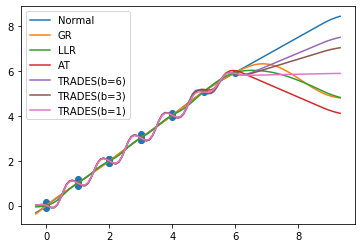

In [11]:
num_examples = 40
np.random.seed(1)
trnX = data_gen(num_examples, weights)
trny = slope*trnX + label_noise(trnX.shape[0], noise_eps)
trnX += generate_x_noise(num_examples)

tstX = data_gen(10000, weights)
tsty = slope*tstX + label_noise(tstX.shape[0], noise_eps)
tstX += generate_x_noise(10000)

X_test, y_test = get_test_set()

theta_normal = get_sol(trnX, trny, tstX, tsty, "normal", cv="nor")
theta_gr = get_sol(trnX, trny, tstX, tsty, "gr", beta=1e-4, cv="adv")
theta_llr = get_sol(trnX, trny, tstX, tsty, "llr", beta=0.01, cv="adv")
theta_adv = get_sol(trnX, trny, tstX, tsty, "adv", cv="adv")
theta_trd_10 = get_sol(trnX, trny, tstX, tsty, "trades", beta=6, cv="adv")
theta_trd_1 = get_sol(trnX, trny, tstX, tsty, "trades", beta=3, cv="adv")
theta_trd_0 = get_sol(trnX, trny, tstX, tsty, "trades", beta=1, cv="adv")

X_plot = np.linspace(-adv_eps, num_stairs-1 + adv_eps, 100)
feats_plot = get_feats(X_plot, knots)
normal_plot_preds = feats_plot.dot(theta_normal)

#plt.scatter(X_test, y_test)
plt.scatter(trnX, trny)
#plt.scatter(tstX, tsty)

plt.plot(X_plot, normal_plot_preds, label="Normal")
gr_plot_preds = feats_plot.dot(theta_gr)
plt.plot(X_plot, gr_plot_preds, label="GR")
llr_plot_preds = feats_plot.dot(theta_llr)
plt.plot(X_plot, llr_plot_preds, label="LLR")
adv_plot_preds = feats_plot.dot(theta_adv)
plt.plot(X_plot, adv_plot_preds, label="AT")
trd_plot_preds = feats_plot.dot(theta_trd_10)
plt.plot(X_plot, trd_plot_preds, label="TRADES(b=6)")
trd_plot_preds = feats_plot.dot(theta_trd_1)
plt.plot(X_plot, trd_plot_preds, label="TRADES(b=3)")
trd_plot_preds = feats_plot.dot(theta_trd_0)
plt.plot(X_plot, trd_plot_preds, label="TRADES(b=1)")
#trd_plot_preds = feats_plot.dot(theta_trd_01)
#plt.plot(X_plot, trd_plot_preds, label="Trades(b=0.01)")
plt.legend()
plt.savefig("./small-stair.png")
#print("Normal")
normal_res = print_results(theta_normal, trnX, trny, tstX, tsty)
gr_res = print_results(theta_gr, trnX, trny, tstX, tsty)
llr_res = print_results(theta_llr, trnX, trny, tstX, tsty)
adv_res = print_results(theta_adv, trnX, trny, tstX, tsty)
trd10_res = print_results(theta_trd_10, trnX, trny, tstX, tsty)
trd1_res = print_results(theta_trd_1, trnX, trny, tstX, tsty)
trd0_res = print_results(theta_trd_0, trnX, trny, tstX, tsty)

df = pd.DataFrame.from_dict({
    "normal": normal_res,
    "GR": gr_res,
    "LLR": llr_res,
    "AT": adv_res,
    "TRADES(6)": trd10_res,
    "TRADES(3)": trd1_res,
    "TRADES(1)": trd0_res,
}, orient="index")
df.columns = ['tr MSE', 'ts MSE', 'adv tr MSE', 'adv ts MSE', 'tr lip(1)', 'ts lip(1)']
df['gap'] = (df['tr MSE'] - df['ts MSE'])
df['adv gap'] = (df['adv tr MSE'] - df['adv ts MSE'])

df = df[['tr MSE', 'ts MSE', 'adv ts MSE', 'ts lip(1)', 'gap', 'adv gap']]

print(df.to_latex(column_format="lc|cc|c|cc", float_format="%.4f", escape=False))

[0.009972567807147753]
[0.009968077253518205]
[0.009964234480299554]
[0.010006993942670638]
[0.010751654737190895]
[0.010212990747530211]
[0.010004973502240713]
\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr MSE &  ts MSE &  adv ts MSE &  ts lip(1) &    gap &  adv gap \\
\midrule
normal    &   0.010 &   0.010 &       0.027 &      0.341 &  0.000 &    0.000 \\
GR        &   0.010 &   0.010 &       0.050 &      0.377 &  0.000 &    0.001 \\
LLR       &   0.010 &   0.010 &       0.015 &      0.272 &  0.000 &    0.001 \\
AT        &   0.010 &   0.010 &       0.014 &      0.251 &  0.000 &    0.001 \\
TRADES(6) &   0.011 &   0.011 &       0.016 &      0.284 & -0.000 &    0.001 \\
TRADES(3) &   0.010 &   0.010 &       0.015 &      0.279 & -0.000 &    0.001 \\
TRADES(1) &   0.010 &   0.010 &       0.015 &      0.277 &  0.000 &    0.001 \\
\bottomrule
\end{tabular}



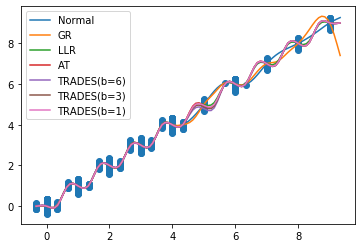

In [10]:
num_examples = 30000
np.random.seed(1)
trnX = data_gen(num_examples, weights)
trny = slope*trnX + label_noise(trnX.shape[0], noise_eps)
trnX += generate_x_noise(num_examples)

tstX = data_gen(15000, weights)
tsty = slope*tstX + label_noise(tstX.shape[0], noise_eps)
tstX += generate_x_noise(15000)


theta_normal = get_sol(trnX, trny, tstX, tsty, "normal", cv="nor")
theta_gr = get_sol(trnX, trny, tstX, tsty, "gr", beta=1e-4, cv="adv")
theta_llr = get_sol(trnX, trny, tstX, tsty, "llr", beta=0.01, cv="adv")
theta_adv = get_sol(trnX, trny, tstX, tsty, "adv", cv="adv")
theta_trd_10 = get_sol(trnX, trny, tstX, tsty, "trades", beta=6, cv="adv")
theta_trd_1 = get_sol(trnX, trny, tstX, tsty, "trades", beta=3, cv="adv")
theta_trd_0 = get_sol(trnX, trny, tstX, tsty, "trades", beta=1, cv="adv")

X_plot = np.linspace(-adv_eps, num_stairs-1 + adv_eps, 100)
feats_plot = get_feats(X_plot, knots)
normal_plot_preds = feats_plot.dot(theta_normal)

#plt.scatter(X_test, y_test)
plt.scatter(trnX, trny)
#plt.scatter(tstX, tsty)

plt.plot(X_plot, normal_plot_preds, label="Normal")
gr_plot_preds = feats_plot.dot(theta_gr)
plt.plot(X_plot, gr_plot_preds, label="GR")
llr_plot_preds = feats_plot.dot(theta_llr)
plt.plot(X_plot, llr_plot_preds, label="LLR")
adv_plot_preds = feats_plot.dot(theta_adv)
plt.plot(X_plot, adv_plot_preds, label="AT")
trd_plot_preds = feats_plot.dot(theta_trd_10)
plt.plot(X_plot, trd_plot_preds, label="TRADES(b=6)")
trd_plot_preds = feats_plot.dot(theta_trd_1)
plt.plot(X_plot, trd_plot_preds, label="TRADES(b=3)")
trd_plot_preds = feats_plot.dot(theta_trd_0)
plt.plot(X_plot, trd_plot_preds, label="TRADES(b=1)")
#trd_plot_preds = feats_plot.dot(theta_trd_01)
#plt.plot(X_plot, trd_plot_preds, label="Trades(b=0.01)")
plt.legend()
plt.savefig("./large-stair.png")
#print("Normal")
normal_res = print_results(theta_normal, trnX, trny, tstX, tsty)
gr_res = print_results(theta_gr, trnX, trny, tstX, tsty)
llr_res = print_results(theta_llr, trnX, trny, tstX, tsty)
adv_res = print_results(theta_adv, trnX, trny, tstX, tsty)
trd10_res = print_results(theta_trd_10, trnX, trny, tstX, tsty)
trd1_res = print_results(theta_trd_1, trnX, trny, tstX, tsty)
trd0_res = print_results(theta_trd_0, trnX, trny, tstX, tsty)

df = pd.DataFrame.from_dict({
    "normal": normal_res,
    "GR": gr_res,
    "LLR": llr_res,
    "AT": adv_res,
    "TRADES(6)": trd10_res,
    "TRADES(3)": trd1_res,
    "TRADES(1)": trd0_res,
}, orient="index")
df.columns = ['tr MSE', 'ts MSE', 'adv tr MSE', 'adv ts MSE', 'tr lip(1)', 'ts lip(1)']
df['gap'] = (df['tr MSE'] - df['ts MSE'])
df['adv gap'] = (df['adv tr MSE'] - df['adv ts MSE'])

df = df[['tr MSE', 'ts MSE', 'adv ts MSE', 'ts lip(1)', 'gap', 'adv gap']]

print(df.to_latex(column_format="lc|cc|c|cc", float_format="%.3f", escape=False))